In [1]:
import torch
import torchvision

n_epochs = 10
batch_size_train = 128
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/content/drive/My Drive/HIP2019/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/content/drive/My Drive/HIP2019/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

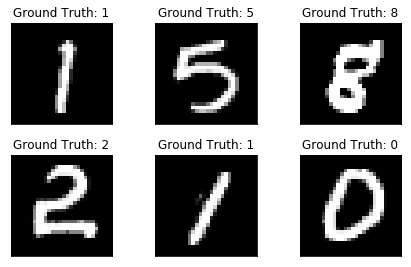

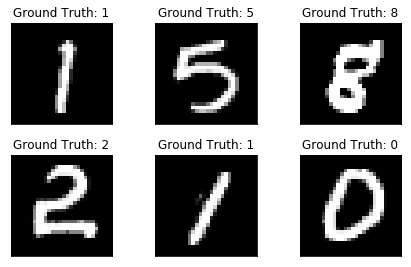

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [0]:
# Neural net architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [0]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
train_losses = []
train_counter = []
validation_losses = []
validation_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/drive/My Drive/HIP2019/MNIST_NN_results/model.pth')
      torch.save(optimizer.state_dict(), '/content/drive/My Drive/HIP2019/MNIST_NN_results/optimizer.pth')

In [0]:
def validation():
  network.eval()
  validation_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in validation_loader:
      output = network(data)
      validation_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  validation_loss /= len(validation_loader.dataset)
  validation_losses.append(validation_loss)
  print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    validation_loss, correct, len(validation_loader.dataset),
    100. * correct / len(validation_loader.dataset)))

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
validation()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validation()
test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Avg. loss: 2.2877, Accuracy: 777/5000 (15%)

Train Epoch: 1 [0/55000 (0%)]	Loss: 2.279739
Train Epoch: 1 [12800/55000 (23%)]	Loss: 1.260586
Train Epoch: 1 [25600/55000 (47%)]	Loss: 0.644774
Train Epoch: 1 [38400/55000 (70%)]	Loss: 0.433017
Train Epoch: 1 [51200/55000 (93%)]	Loss: 0.292032

Validation set: Avg. loss: 0.3757, Accuracy: 4468/5000 (89%)

Train Epoch: 2 [0/55000 (0%)]	Loss: 0.422202
Train Epoch: 2 [12800/55000 (23%)]	Loss: 0.382096
Train Epoch: 2 [25600/55000 (47%)]	Loss: 0.319710
Train Epoch: 2 [38400/55000 (70%)]	Loss: 0.207373
Train Epoch: 2 [51200/55000 (93%)]	Loss: 0.170567

Validation set: Avg. loss: 0.2957, Accuracy: 4576/5000 (91%)

Train Epoch: 3 [0/55000 (0%)]	Loss: 0.375356
Train Epoch: 3 [12800/55000 (23%)]	Loss: 0.316962
Train Epoch: 3 [25600/55000 (47%)]	Loss: 0.294818
Train Epoch: 3 [38400/55000 (70%)]	Loss: 0.253285
Train Epoch: 3 [51200/55000 (93%)]	Loss: 0.267334

Validation set: Avg. loss: 0.2536, Accuracy: 4644/5000 (92%)

Train Epoch: 4